# Multi-Objective Optimization
**Prepared by:** [Shammah Lilonfe](https://www.linkedin.com/in/shammah-lilonfe-34956214a?utm_source=share&utm_campaign=share_via&utm_content=profile&utm_medium=android_app) ([slilonfe@nd.edu](mailto:slilonfe@nd.edu), 2024) and Zhicheng Lu ([zlu3@nd.edu](mailto:zlu3@nd.edu), 2024) at the University of Notre Dame.

Notes for edits:
* Add standard imports so this runs on Colab and locally
* Remove material in prior notebook
* Verify notebook runs
* Adjust equation numbering

In [ ]:
import sys

if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
else:
    sys.path.insert(0, '../')
    import helper

    # Loads IPOPT and other solvers
    import idaes

helper.set_plotting_style()

# Importing packages to be used in this project
import pyomo.environ as pyo
import pyomo.dae as dae
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Learning Objectives

* Explain the modelling strategies of multi-objective optimization (MOO)
* Demonstrate the power of MOO in solving chemical industry problems

## Basic Definitions

Let $\mathbf{x} \in \mathbb{R}^{n_x}$ be the decision vector that lies in the feasible set $X \subseteq \mathbb{R}^{n_x}$, which is assumed to be compact and nonempty. Given  $n$ objective functions $f_i: X \to \mathbb{R}$ for $i \in O:$ = {1, 2, $\dots, n$}, and the corresponding objective vector: $\mathbf{f}(\mathbf{x}) = \big(f_1(\mathbf{x}), f_2(\mathbf{x}), \dots, f_{n}(\mathbf{x})\big)$. Assuming that the objective functions remain bounded in $X$.

The MOO problem is defined as:
$$\begin{equation}
\min_{x \in X} \big(f_1(x), f_2(x), \dots, f_{n}(x)\big) \tag{1.1}
\end{equation}$$

Again, we assume that the minimization operand implies global minimization and that the objective functions have been scaled so that their values lie in the interval [0, 1].

This was taken from Dowling et al. (2016).

### Scaling

Scaling of the objective functions is performed using the coordinates of the utopia and nadirpoints as follows. We define:
\begin{equation}
\underline{f}_i = \min_{x \in X} f_i(x), \quad i \in O \tag{1.2a}
\end{equation}
\begin{equation}
\underline{x}_i = \arg\min_{x \in X} f_i(x), \quad i \in O. \tag{1.2b}
\end{equation}
Here, the coordinates of the utopia point are given by $\underline{f}_i$, while those of the nadir point are given by:
\begin{equation}
\bar{f}_i = \max \{ f_i(\underline{x}_1), f_i(\underline{x}_2), \dots, f_i(\underline{x}_{n}) \}, \quad i \in O. \tag{1.3}
\end{equation}
The objectives are scaled as follows:
\begin{equation}
f_i(x) \leftarrow \frac{f_i(x) - \underline{f}_i}{\bar{f}_i - \underline{f}_i}, \quad i \in O. \tag{1.4}
\end{equation}

We can prevent visiting regions beyond the nadir points by imposing the constraints:
\begin{equation}
0 \leq f_i(x) \leq 1, \quad i \in O. \tag{1.5}
\end{equation}

This was taken from Dowling et al. (2016).

### Pareto Optimality

Below are the standard definitions of weak Pareto optimality and Pareto optimality (Miettinen, 1999):

**Definition 1 (Weak Pareto Optimality)**: A decision $x^*$ with objectives $f_i(x^*), \, i \in O$ is a weak Pareto solution of MOO if there does not exist an alternate solution $x$ with objectives $f_i(x), \, i \in O$ which satisfies $f_i(x) < f_i(x^*)$ for all  $i \in O$.

**Definition 2 (Pareto Optimality)**: A decision $x^*$ with objectives $f_i(x^*), \, i \in O$ is a Pareto solution of MOO if there does not exist an alternate solution $x$ with objectives $f_i(x), \, i \in O$ which satisfies $f_i(x) \leq f_i(x^*)$ for all $i \in O$ and at least one index $i$ satisfies $f_i(x) < f_i(x^*)$.

Any Pareto solution of MOO is a weak Pareto solution. To see this, we consider the following contradiction: assume $x^*$ is a Pareto solution, and thus no alternate decision $x$ exists such that $f_i(x) \leq f_i(x^*)$ for all $i \in O$ and $f_i(x) < f_i(x^*)$ for at least one index $i$. If, in addition, we assume that $x^*$ is not weak Pareto, then there exists an alternate decision $x$ such that $f_i(x) < f_i(x^*)$ for all $i \in O$. This is a contradiction, and thus $x^*$ must be a Pareto and a weak Pareto solution.

The set of all Pareto solutions for MOO is known as the Pareto set. There are different methods that can be used to compute elements of the Pareto set, such as the weighting method. The results associated with this method will become relevant in the following sections.

Consider a weight vector $\mathbf{w} \in \mathbb{R}^n$ and assume that this satisfy the conditions:
\begin{equation}
w_i \geq 0, \quad i \in O, \tag{1.6a}
\end{equation}
\begin{equation}
\sum_{i \in O} w_i = 1. \tag{1.6b}
\end{equation}

In some cases, we will require the weights to satisfy the stronger condition:
\begin{equation}
w_i > 0, \quad i \in O \tag{1.7a}
\end{equation}
\begin{equation}
\sum_{i \in O} w_i = 1. \tag{1.7b}
\end{equation}

Consider now the weighted problem:
\begin{equation}
\min_{x \in X} \mathbf{w}^T \mathbf{f}(\mathbf{x}). \tag{1.8}
\end{equation}

The solutions of this problem satisfy the following property:

**Proposition 1**: Let $x^*$ be a solution of the weighted problem (1.8):
* If the weight vector $\mathbf{w}$ satisfies $w_i \geq 0, \, i \in O$ (Condition 1.6a), then $x^*$ is a weak Pareto solution of MOO.
* If the weight vector $\mathbf{w}$ satisfies $w_i > 0, \, i \in O$ (Condition 1.7a), then $x^*$ is a Pareto solution of MOO.

The nadir point is obtained by computing worst-case value results of the utopia point as in (1.2) and (1.3). The nadir point coordinates are determined by minimizing each objective function and then obtaining the corresponding worst-case values for the objectives. This approach is equivalent to solving (1.1) with $w_i=1$ and $w_{i' \neq i}=0$ for $i, i' ∈ O$. From Proposition 1, these single objective solutionsare only weak Pareto solutions. Consequently, it is possible to achieve a further reduction in the other objectives without compromising the original single objective. Because of this, the nadir point may unnecessarily enlarges the decision space. This inturn impacts the scaling of the objectives in (1.4). To address this issue, an alternate nadir point is exploited.

**Definition 3 (Alternate Nadir Point)**: Let $\underline{x}_i$ and $\underline{f}_i$ be defined as in (1.2) for all $i \in O$. For each $i \in O$, let the alternate nadir solution $\underline{x}^*_i$ be defined as:
\begin{equation}
\underline{x}^*_i = \arg\min_{x \in X} \mathbf{w}^T \mathbf{f}(\mathbf{x}) 
\end{equation}
\begin{equation}
\text{s.t.} \quad f_i(x) \leq \underline{f}_i, \tag{1.9}
\end{equation}

where $\mathbf{w}$ satisfies $w_i = 0$ and $w_{i' \neq i} > 0$. 

The alternate nadir point $\mathbf{\bar{f}}^*$ with elements $\bar{f}^*_i$ is defined as:
\begin{equation}
\bar{f}^*_i = \max\{f_i(\underline{x}^*_1), f_i(\underline{x}^*_2), \ldots, f_i(\underline{x}^*_{n})\}, \quad i \in O. \tag{1.10}
\end{equation}

**Proposition 2**: The alternate nadir solutions $\underline{x}^*_i$ for $i \in O$, are Pareto solutions of MOO.

The alternate nadir point method requires a selection of weights for the objective functions. Such a selection is not unique and thus different alter-nate nadir solutions can be obtained. However, all of these alternatives are guaranteed to be Pareto solutions. Even small nonzero weights guarantee this property and thus the alternate nadir point can be designed to prevent extreme degeneracies of the objectives resulting from the standard use of (1.2) and (1.3). 

Computing all the elements in the the Pareto set is computationally intractable, particularly when many objectives are considered. It is well known, however, that one can compute Pareto optimal compromise solutions by finding points that are closest in distance to the utopia point. This is often done by solving the minimization problem:

\begin{equation}
\min_{x \in X} \|f(\mathbf{x})\|_p, \tag{1.11}
\end{equation}

where $\|\cdot\|_p$ is the $L_p$ norm.
\begin{equation}
\|f(\mathbf{x})\|_p = 
\left( 
\sum_{i \in O} f_i(x)^p 
\right)^{1/p}, \quad p \geq 1, \tag{1.12}
\end{equation}

**Proposition 3**. A solution $x^*$ of the minimum distance problem (1.11) is a Pareto solution of MOO.

This was taken from Dowling et al. (2016).

## Epsilon-Constraint Method

### Key Concepts

In MOO, the goal is to minimize a vector of objective functions:

$$\begin{equation}
\min_{x \in X} \big(f_1(x), f_2(x), \dots, f_{n}(x)\big)
\end{equation}$$

Subject to:
$$\begin{equation}
g_j(x) \leq 0, \quad j = 1, \dots, m. \tag{2.1}
\end{equation}$$

Where $f_1, f_2, \dots, f_n$ are the objectives, and $g_j(x)$ are problem-specific constraints.

The epsilon-constrained method reformulates this problem by optimizing one objective function (e.g., $f_1(x)$), while treating the remaining objectives as constraints with thresholds $\epsilon_i$ for $i \in O:$ = {1, 2, $\dots, n$}. The reformulated problem is expressed as:

$$\begin{equation}
\min_{x \in X} \big(f_1(x)\big)
\end{equation}$$

Subject to:
$$\begin{equation}
f_2(x) \leq \epsilon_2, \quad f_3(x) \leq \epsilon_3, \quad \dots, \quad f_n(x) \leq \epsilon_n,
\end{equation}$$
$$\begin{equation}
g_j(x) \leq 0, \quad j = 1, \dots, m. \tag{2.2}
\end{equation}$$

Adopted from Miettinen (1999).

### Key Points

* **Trade-Off Exploration**: By systematically varying the values of $\epsilon_2, \epsilon_3, \dots, \epsilon_n$, it is possible to explore trade-offs between objectives and construct an approximation of the Pareto front.
* **Reduction to Single Objective**: The epsilon-constrained method simplifies the multi-objective problem into a single-objective problem for each choice of $\epsilon$ values.
* **Flexibility**: Any one of the objectives can be chosen as the primary objective to optimize, allowing the user to prioritize specific goals.

Miettinen (1999).

## Example: Design of Chemical Reactors for Chemical Transformations

Chemical reactors are often the most important unit operations in a chemical plant. Reactors come in many forms, however two of the most common idealizations are the continuously stirred tank reactor (CSTR) and the plug flow reactor. The CSTR is often used in modeling studies, and it can be effectively modeled as a lumped parameter system. In this example, we will consider the following reaction scheme known as the Van de Vusse reaction:

$$
\text{A} \xrightarrow{k_1} \text{B} \xrightarrow{k_2} \text{C}
$$

$$
2\text{A} \xrightarrow{k_3} \text{D}
$$

A diagram of the system is shown in figure below, where F is the volumetric flowrate. The reactor is assumed to be filled to a constant volume, and the mixture is assumed to have constant density, so the volumetric flowrate into the reactor is equal to the volumetric flowrate out of the reactor. Since the reactor is assumed to be wellmixed, the concentrations in the reactor are equivalent to the concentrations of each component flowing out of the reactor, given by $C_A$, $C_B$, $C_C$, and $C_D$.

![process scheme](../../media/contrib/reactor.png)


This example (both text and figure) was taken from Hart et al (2017).

See [](../contrib/reactor_design.ipynb) for the extension of this example to design a batch reactor. This notebook extends the batch reactor problem into a multi-objective optimization problem.


## Multi-Objective Optimization to Maximize Species B and C

In this project, species B and C are the desired products, and we are considering the dynamic state of the system (most often, industrial operations are dynamic). The goal of this work is to determine the volume of the reactor that will maximize the concentration of species B and C in the effluent after 10 minutes. Furthermore, for economic reasons, the reactor volume should not exceed $\mathrm{100\,m^3}$.

The mole balance for each of the species in this system under dynamic state is given by:

$$\begin{align*}
&\frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B\\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2
\end{align*}$$

Where $C_A$, $C_B$, $C_C$ and $C_D$ are the concentrations of species A, B, C and D, respectively. $F$ is the feed flow rate, $C_{Af}$ is the concentration of species A in the feed, $k_1$, $k_2$ and $k_3$ are the rate constants of reaction 1 (species A to B), reaction 2 (species B to C) and reaction 3 (species A to D), respectively.

The data for the system are:
$$\begin{align*}
C_{Af}=10^4\,\mathrm{\frac{mol}{m^3}},\quad{k_1=\frac{5}{6}\,\mathrm{min^{-1}}},\quad{k_2=\frac{5}{3}\,\mathrm{min^{-1}}},\quad{k_3=\frac{1}{6000}\,\mathrm{\frac{m^3}{mol\cdot min}}},\quad{F=1\,\mathrm{\frac{m^3}{min}}}
\end{align*}$$

The data was obtained from Hart et al (2017).

### Optimization Model Formulation

Mathematically, we want to solve the following optimal reactor volume problem:

$$\begin{align*}
\max_{V} \quad & (C_B(t=10),\, C_C(t=10)) \\
\mathrm{s.t.} \quad & \frac{dC_A}{dt}=\frac{F}{V}C_{Af}-\frac{F}{V}C_A-k_1C_A-2k_3C_A^2 \\
& \frac{dC_B}{dt}=-\frac{F}{V}C_B+k_1C_A-k_2C_B \\
& \frac{dC_C}{dt}=-\frac{F}{V}C_C+k_2C_B \\
& \frac{dC_D}{dt}=-\frac{F}{V}C_D+k_3C_A^2 \\
& V \leq 100 \\
& C_A(t=0) = 10000, ~~ C_B(t=0) = 0 \\
& C_C(t=0) = 0, ~~ C_D(t=0) = 0 \\
\end{align*}$$

### Degrees of Freedom Analysis

From the optimization model formulated above:

Number of variables = 5

Number of equality constraints = 4

Therefore, the degrees of freedom = 5 - 4 = 1

### Weighted Method Pyomo Implementation

In [4]:
# parameters
conc_A_feed = 10000  # mol/m^3
k1 = 5 / 6  # min^-1
k2 = 5 / 3  # min^-1
k3 = 1 / 6000  # m^3/mol/min
feed_flowrate = 1  # m^3/min

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

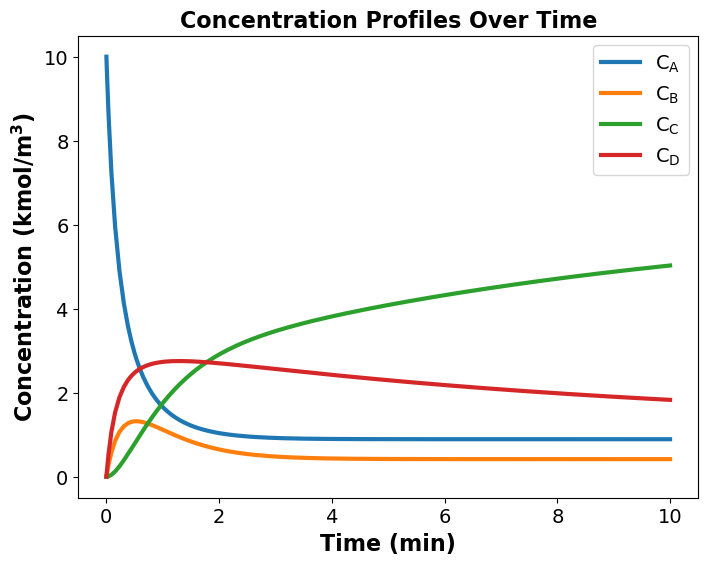

In [5]:
# Function for weighted method multi-objective dynamic model
def weighted_reactor_model(F, CAF, k1, k2, k3, w1, w2):
    """Creates reactor model with multi-objective optimization
    Arguments:
        F: feed volumetric flow rate in m^3/min
        CAF: feed concentration of A, gmol/m^3
        k1: rate constant for A to B, min^-1
        k2: rate constant for B to C, min^-1
        k3: rate constant for 2A to D, m^3/(gmol.min)
        w1: weights for objective 1
        w2: weights for objective 2

    Returns:
        model: pyomo model
    """

    # Create Pyomo model
    model = pyo.ConcreteModel()

    # Define time as a continuous set
    model.t = dae.ContinuousSet(bounds=(0, 10))  # Time from 0 to 10 minutes

    # Define variables
    model.CA = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Concentration of A
    model.CB = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Concentration of B
    model.CC = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Concentration of C
    model.CD = pyo.Var(model.t, within=pyo.NonNegativeReals)  # Concentration of D
    model.V = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, 100), initialize=11.35)  # Reactor volume

    # Define derivatives
    model.dCA_dt = dae.DerivativeVar(model.CA, wrt=model.t)
    model.dCB_dt = dae.DerivativeVar(model.CB, wrt=model.t)
    model.dCC_dt = dae.DerivativeVar(model.CC, wrt=model.t)
    model.dCD_dt = dae.DerivativeVar(model.CD, wrt=model.t)

    # CA differential equation
    def ca_rate_ode(m, t):
        return m.dCA_dt[t] == (F / m.V) * CAF - (F / m.V) * m.CA[t] - k1 * m.CA[t] - 2 * k3 * m.CA[t] ** 2
    model.CA_ode = pyo.Constraint(model.t, rule=ca_rate_ode)

    # CB differential equation
    def cb_rate_ode(m, t):
        return m.dCB_dt[t] == -(F / m.V) * m.CB[t] + k1 * m.CA[t] - k2 * m.CB[t]
    model.CB_ode = pyo.Constraint(model.t, rule=cb_rate_ode)

    # CC differential equation
    def cc_rate_ode(m, t):
        return m.dCC_dt[t] == -(F / m.V) * m.CC[t] + k2 * m.CB[t]
    model.CC_ode = pyo.Constraint(model.t, rule=cc_rate_ode)

    # CD differential equation
    def cd_rate_ode(m, t):
        return m.dCD_dt[t] == -(F / m.V) * m.CD[t] + k3 * m.CA[t] ** 2
    model.CD_ode = pyo.Constraint(model.t, rule=cd_rate_ode)
    
    # Initial conditions
    def init_conditions(m):
        yield m.CA[0] == CAF
        yield m.CB[0] == 0
        yield m.CC[0] == 0
        yield m.CD[0] == 0
    model.init_conditions = pyo.ConstraintList(rule=init_conditions)

    # Multi-objective function: weighted sum of objectives
    # Maximize CC (product C), CB (intermediate B)
    def objective_function(m):
        return w1 * m.CC[10] + w2 * m.CB[10]
    model.objective = pyo.Objective(rule=objective_function, sense=pyo.maximize)

    return model

# Weights for multi-objective function
weights = {"w1": 0.5, "w2": 0.5}

# Create reactor model
reactor_model = weighted_reactor_model(feed_flowrate, conc_A_feed, k1, k2, k3, weights["w1"], weights["w2"])

# Discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(reactor_model, nfe=20, ncp=10)

# Solve the model
solver = pyo.SolverFactory('ipopt')
results = solver.solve(reactor_model, tee=True)

# Print results
optimal_volume = pyo.value(reactor_model.V)
optimal_CC = pyo.value(reactor_model.CC[10]) * 1e-3  # kmol/m^3
optimal_CB = pyo.value(reactor_model.CB[10]) * 1e-3  # kmol/m^3

print(f"Optimal reactor volume: {round(optimal_volume, 2)} m^3")
print(f"Maximum Concentration of C at optimal reactor volume is: {round(optimal_CC, 2)} kmol/m^3")
print(f"Maximum Concentration of B at optimal reactor volume is: {round(optimal_CB, 2)} kmol/m^3")

# Extract results for plotting
time = [t for t in reactor_model.t] # minutes
CA_values = [(pyo.value(reactor_model.CA[t])*10**(-3)) for t in time] # kmol/m^3
CB_values = [(pyo.value(reactor_model.CB[t])*10**(-3)) for t in time] # kmol/m^3
CC_values = [(pyo.value(reactor_model.CC[t])*10**(-3)) for t in time] # kmol/m^3
CD_values = [(pyo.value(reactor_model.CD[t])*10**(-3)) for t in time] # kmol/m^3

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(time, CA_values, label='$\mathrm{C_{A}}$')
plt.plot(time, CB_values, label='$\mathrm{C_{B}}$')
plt.plot(time, CC_values, label='$\mathrm{C_{C}}$')
plt.plot(time, CD_values, label='$\mathrm{C_{D}}$')
plt.xlabel('Time (min)', fontsize=16,fontweight='bold')
plt.ylabel('Concentration (kmol/$\mathbf{m^3}$)', fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Concentration Profiles Over Time', fontsize=16,fontweight='bold')
plt.legend()
plt.show()


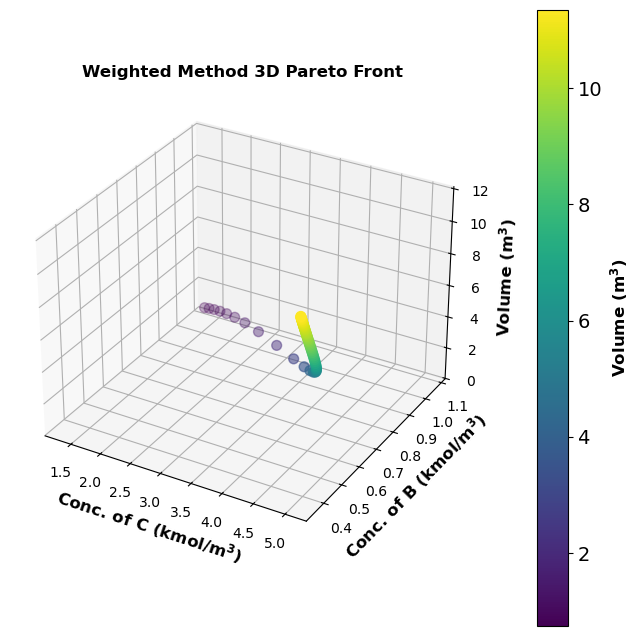

In [6]:
# Visualizing Pareto Front
def generate_weights(n_points): # Function to systematically generate weight combinations
    """Creates weights for objective function
    Argument:
        n_points: number of points to evaluate weights

    Returns:
        w1: weight vector for objective 1
        w2: weight vector for objective 2"""
    
    w1 = np.linspace(0, 1, n_points)
    w2 = [1 - w1[i] for i in range(len(w1))]
    return w1, w2

# number of points for weights
n_points = 60

# Generate valid weight combinations
w1, w2 = generate_weights(n_points)

# Generate Pareto front by scanning weights
pareto_data = []

# Iterate over each weight combination
for i in range(len(w1)):
    # Create and solve the model with the given weights
    reactor_model = weighted_reactor_model(feed_flowrate, conc_A_feed, k1, k2, k3, w1[i], w2[i])
    discretizer = pyo.TransformationFactory('dae.collocation')
    discretizer.apply_to(reactor_model, nfe=20, ncp=10)
    solver = pyo.SolverFactory('ipopt')
    results = solver.solve(reactor_model, tee=False)

    if results.solver.termination_condition == pyo.TerminationCondition.optimal:
        optimal_volume = pyo.value(reactor_model.V)
        optimal_CC = pyo.value(reactor_model.CC[10]) * 1e-3  # kmol/m^3
        optimal_CB = pyo.value(reactor_model.CB[10]) * 1e-3  # kmol/m^3
        pareto_data.append((w1[i], w2[i], optimal_CC, optimal_CB, optimal_volume))

# Convert Pareto data to a structured format for analysis
pareto_df = pd.DataFrame(pareto_data, columns=["w1", "w2", "CC", "CB", "V"])

# Plotting the 3D Pareto front
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(pareto_df['CC'], pareto_df['CB'], pareto_df['V'], c=pareto_df['V'], cmap='viridis', s=50)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)
ax.tick_params(direction="in",top=True, right=True)
ax.set_xlabel('Conc. of C (kmol/$\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_ylabel('Conc. of B (kmol/$\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_zlabel('Volume ($\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_title('Weighted Method 3D Pareto Front', fontsize=12,fontweight='bold')
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Volume ($\mathbf{m^3}$)', fontsize=12,fontweight='bold')
plt.show()

### Epsilon-Constraint Method Pyomo Implementation

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

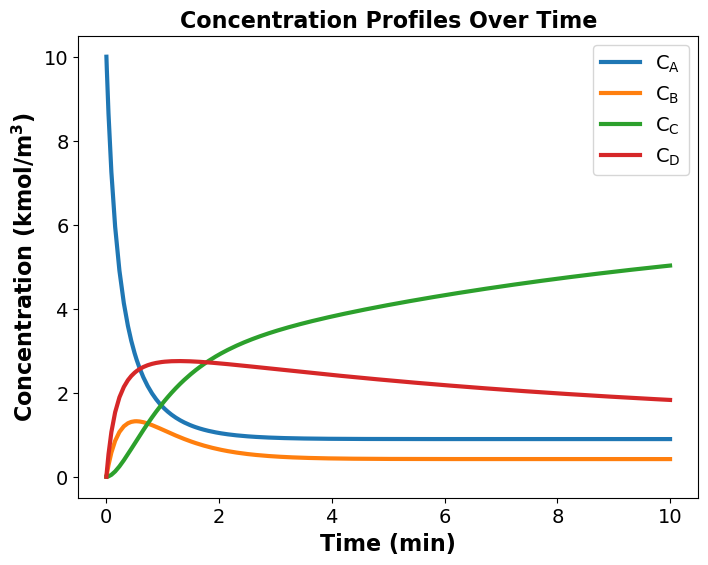

In [7]:
# Function for epsilon-constraint method multi-objective dynamic model
def create_epsilon_model(F, CAF, k1, k2, k3, epsilon_CB):
    """Solves multi-objective optimization using epsilon constraint method
    Arguments:
        F: feed volumetric flow rate in m^3/min
        CAF: feed concentration of A, gmol/m^3
        k1: rate constant for A to B, min^-1
        k2: rate constant for B to C, min^-1
        k3: rate constant for 2A to D, m^3/(gmol.min)
        epsilon_CB: constraint threshold of concentration of B

    Returns:
        model: pyomo model
    """

    model = pyo.ConcreteModel()

    # Define time as a continuous set
    model.t = dae.ContinuousSet(bounds=(0, 10))
    
    # Variables
    model.CA = pyo.Var(model.t, within=pyo.NonNegativeReals)
    model.CB = pyo.Var(model.t, within=pyo.NonNegativeReals)
    model.CC = pyo.Var(model.t, within=pyo.NonNegativeReals)
    model.CD = pyo.Var(model.t, within=pyo.NonNegativeReals)
    model.V = pyo.Var(within=pyo.NonNegativeReals, bounds=(0, 100), initialize=1)
    
    # Derivatives
    model.dCA_dt = dae.DerivativeVar(model.CA, wrt=model.t)
    model.dCB_dt = dae.DerivativeVar(model.CB, wrt=model.t)
    model.dCC_dt = dae.DerivativeVar(model.CC, wrt=model.t)
    model.dCD_dt = dae.DerivativeVar(model.CD, wrt=model.t)
    
    # CA differential equation
    def ca_rate_ode(m, t):
        return m.dCA_dt[t] == (F / m.V) * CAF - (F / m.V) * m.CA[t] - k1 * m.CA[t] - 2 * k3 * m.CA[t] ** 2
    model.CA_ode = pyo.Constraint(model.t, rule=ca_rate_ode)

    # CB differential equation
    def cb_rate_ode(m, t):
        return m.dCB_dt[t] == -(F / m.V) * m.CB[t] + k1 * m.CA[t] - k2 * m.CB[t]
    model.CB_ode = pyo.Constraint(model.t, rule=cb_rate_ode)

    # CC differential equation
    def cc_rate_ode(m, t):
        return m.dCC_dt[t] == -(F / m.V) * m.CC[t] + k2 * m.CB[t]
    model.CC_ode = pyo.Constraint(model.t, rule=cc_rate_ode)

    # CD differential equation
    def cd_rate_ode(m, t):
        return m.dCD_dt[t] == -(F / m.V) * m.CD[t] + k3 * m.CA[t] ** 2
    model.CD_ode = pyo.Constraint(model.t, rule=cd_rate_ode)

    # Initial conditions
    def init_conditions(m):
        yield m.CA[0] == CAF
        yield m.CB[0] == 0
        yield m.CC[0] == 0
        yield m.CD[0] == 0
    model.init_conditions = pyo.ConstraintList(rule=init_conditions)
    
    # Epsilon constraints 
    model.epsilon_constraint_CB = pyo.Constraint(expr=model.CB[10] >= epsilon_CB) # converting CB to constraint
    
    # Objective: Minimize volume
    model.objective = pyo.Objective(expr=model.CC[10], sense=pyo.maximize)
    
    return model

# constraint threshold
epsilon_CB_values = 420

# Create reactor model
reactor_model_epsilon = create_epsilon_model(feed_flowrate, conc_A_feed, k1, k2, k3, epsilon_CB_values)

# Discretize the model using collocation
discretizer = pyo.TransformationFactory('dae.collocation')
discretizer.apply_to(reactor_model_epsilon, nfe=20, ncp=10)

solver = pyo.SolverFactory('ipopt')
result = solver.solve(reactor_model_epsilon, tee=True)

if (result.solver.status == pyo.SolverStatus.ok) and (result.solver.termination_condition == pyo.TerminationCondition.optimal):
    print("Solver found an optimal solution.")
    optimal_volume = pyo.value(reactor_model_epsilon.V)
    final_concentration_C = pyo.value(reactor_model_epsilon.CC[10]) * 1e-3
    final_concentration_B = pyo.value(reactor_model_epsilon.CB[10]) * 1e-3

    print(f"Optimal Reactor Volume: {optimal_volume:.2f} m^3")
    print(f"Maximum Concentration of B at optimal reactor volume is: {final_concentration_B:.2f} kmol/m^3")
    print(f"Maximum Concentration of C at optimal reactor volume is: {final_concentration_C:.2f} kmol/m^3")
else:
    print("Solver did not find an optimal solution. Status:", result.solver.status)

# Extract results for plotting
time = [t for t in reactor_model_epsilon.t] # minutes
CA_values = [(pyo.value(reactor_model_epsilon.CA[t])*10**(-3)) for t in time] # kmol/m^3
CB_values = [(pyo.value(reactor_model_epsilon.CB[t])*10**(-3)) for t in time] # kmol/m^3
CC_values = [(pyo.value(reactor_model_epsilon.CC[t])*10**(-3)) for t in time] # kmol/m^3
CD_values = [(pyo.value(reactor_model_epsilon.CD[t])*10**(-3)) for t in time] # kmol/m^3

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(time, CA_values, label='$\mathrm{C_{A}}$')
plt.plot(time, CB_values, label='$\mathrm{C_{B}}$')
plt.plot(time, CC_values, label='$\mathrm{C_{C}}$')
plt.plot(time, CD_values, label='$\mathrm{C_{D}}$')
plt.xlabel('Time (min)', fontsize=16,fontweight='bold')
plt.ylabel('Concentration (kmol/$\mathbf{m^3}$)', fontsize=16,fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Concentration Profiles Over Time', fontsize=16,fontweight='bold')
plt.legend()
plt.show()


    epsilon_CB  optimal_volume  opt_concentration_CB  opt_concentration_CC
0   400.000000        9.643572            399.999996           5044.649783
1   406.122449        9.431184            406.122445           5040.039755
2   412.244898        9.225387            412.244894           5034.826198
3   418.367347        9.025888            418.367343           5029.012010
4   424.489796        8.832410            424.489792           5022.600211
5   430.612245        8.644690            430.612241           5015.593948
6   436.734694        8.462483            436.734690           5007.996486
7   442.857143        8.285555            442.857138           4999.811213
8   448.979592        8.113687            448.979587           4991.041629
9   455.102041        7.946670            455.102036           4981.691353
10  461.224490        7.784306            461.224485           4971.764111
11  467.346939        7.626410            467.346934           4961.263742
12  473.469388        7.4

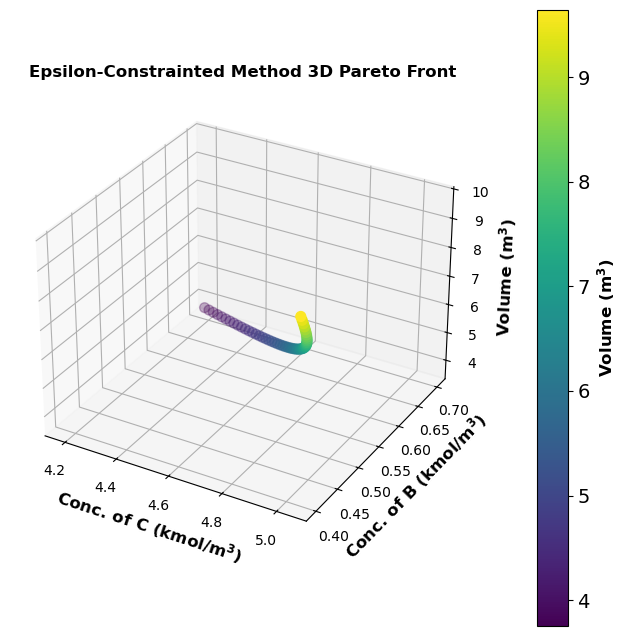

In [8]:
# Visualizing Pareto Front
num_samples = 50  # sample amount

# constraint threshold
epsilon_CB_values = np.linspace(400, 700, num_samples)

# Store results
results = []

# loop through all constraint threshold values
for epsilon_CB in epsilon_CB_values:
    reactor_model_epsilon = create_epsilon_model(feed_flowrate, conc_A_feed, k1, k2, k3, epsilon_CB) # reactor model

    # Discretize the model using collocation
    discretizer = pyo.TransformationFactory('dae.collocation')
    discretizer.apply_to(reactor_model_epsilon, nfe=20, ncp=10)
    
    solver = pyo.SolverFactory('ipopt')
    result = solver.solve(reactor_model_epsilon, tee=False)

    if (result.solver.status == pyo.SolverStatus.ok and result.solver.termination_condition == pyo.TerminationCondition.optimal):
        optimal_volume = pyo.value(reactor_model_epsilon.V)
        opt_concentration_CB = pyo.value(reactor_model_epsilon.CB[10])
        opt_concentration_CC = pyo.value(reactor_model_epsilon.CC[10])

        results.append({
            'epsilon_CB': epsilon_CB,
            'optimal_volume': optimal_volume,
            'opt_concentration_CB': opt_concentration_CB,
            'opt_concentration_CC': opt_concentration_CC
        })
    else:
        print(f"Failed to find optimal solution for ε_CB = {epsilon_CB}")

results_df = pd.DataFrame(results)

print(results_df)

# Plotting the 3D Pareto front
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(projection='3d')
scatter = ax.scatter(results_df['opt_concentration_CC']*1e-3, results_df['opt_concentration_CB']*1e-3, results_df['optimal_volume'], c=results_df['optimal_volume'], cmap='viridis', s=50)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.tick_params(axis='z', labelsize=10)
ax.tick_params(direction="in",top=True, right=True)
ax.set_xlabel('Conc. of C (kmol/$\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_ylabel('Conc. of B (kmol/$\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_zlabel('Volume ($\mathbf{m^3}$)', fontsize=12,fontweight='bold')
ax.set_title('Epsilon-Constrainted Method 3D Pareto Front', fontsize=12,fontweight='bold')
color_bar = fig.colorbar(scatter, ax=ax, pad=0.1)
color_bar.set_label('Volume ($\mathbf{m^3}$)', fontsize=12,fontweight='bold')
plt.show()

## MOO Identifies the Lowest Reactor Volume and Offers Control over Production

* From the results of the two MOO methods, it can be seen that MOO identifies the lowest reactor volume ($\mathrm{\sim 9\,m^3}$) for an even higher species B concentration of $\mathrm{0.42\, kmol/m^3}$, compared to single objective optimization in [Extension 1](https://github.com/zhichenglu123/optimization/blob/main/notebooks/contrib-dev/reactor_design.ipynb) where the optimum reactor volume is $\mathrm{11.4\,m^3}$ and species B concentration is $\mathrm{0.36\,kmol/m^3}$.

* MOO offer engineers the ability to select the product with highest priority, thereby enpowering stakeholders control over product yields.


## Take Away Messages

* Pyomo continues to be a powerful tool in solving complex dynamic optimization problems.
* Multi-objective optimization provides control over desired outcomes and products.
* Multi-objective optimization identifies solutions that are robust to stakeholders decision.
* Proper modeling of the problem is key to obtaining quality results.

Future work ideas:
* Compare the Pareto sets generated with the two methods
* Add another example with a non-convex Pareto set to highlight the difference between the methods

## References
Dowling, A. W., Ruiz-Mercado, G., & Zavala, V. M. (2016). A framework for multi-stakeholder decision-making and conflict resolution. Computers & Chemical Engineering, 90, 136-150.

Hart, W. E., Laird, C. D., Watson, J. P., Woodruff, D. L., Hackebeil, G. A., Nicholson, B. L., & Siirola, J. D. (2017). Pyomo-optimization modeling in python (Vol. 67, p. 277). Berlin: Springer.

Miettinen, K. (1999). Nonlinear multiobjective optimization (Vol. 12). Springer Science & Business Media.